In [1]:
import pandas as pd
import nltk
import re
import string
from collections import defaultdict
import numpy as np
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import threading
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
import time
from timeit import default_timer as timer

basic_stopwords = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

basic_stopwords = stopwords.words('english')

df = pd.read_csv("dataset2.csv",encoding='latin')
df = df.drop(df.columns[[1,2,3,4]],axis=1)
df = df.rename(columns={df.columns[0]: 'target', df.columns[1]: 'tweet'})

closed_categories = ['CC', 'CD', 'DT', 'EX', 'IN', 'LS', 'MD', 'PDT', 'POS', 'PRP', 'PRP$', 'RP', 'TO', 'UH', 'WDT',
                     'WP', 'WP$', 'WRB']

vocabulary = []

def custom_lemmatizer(word, pos_tag): #takes as argument the word and the pos tag

    flag = 0
    for tag in closed_categories:
        if pos_tag == tag: #if pos tag is a close category tag, the functions returns flag with value 1
            flag = 1
            return word
    if flag == 0: #if not , the word gets lemmatized according to its part of speech
        if pos_tag.startswith("N"):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.NOUN)
#             vocabulary.append(word)
            return (word)
        elif pos_tag.startswith('V'):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.VERB)
#             vocabulary.append(word)
            return (word)
        elif pos_tag.startswith('J'):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.ADJ)
            vocabulary.append(word)
            return (word)
        elif pos_tag.startswith('R'):
            word = wordnet_lemmatizer.lemmatize(word, wordnet.ADV)
#             vocabulary.append(word)
            return (word)
        else:
            return word

punctuation = string.punctuation
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',tweet)
    tweet = re.sub(r"@\S+", "", tweet)                
    tweet = nltk.word_tokenize(tweet)
    remove_punctuation = str.maketrans('', '', punctuation)
    tweet = [word.translate(remove_punctuation) for word in tweet if word not in basic_stopwords and word.isalnum() and not word.isdigit()]
#     tweet = [PorterStemmer().stem(word) for word in tweet]
    tagged_tweet = nltk.pos_tag(tweet)
    tweet = [custom_lemmatizer(word[0],word[1]) for word in tagged_tweet]
    tweet = [word for word in tweet if word is not None]
    
    return tweet

start = timer()
df.tweet =df.tweet.apply(lambda x:preprocess(x)) 
end = timer()
print(end-start)

[nltk_data] Downloading package wordnet to /home/antonis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/antonis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


727.9449108589979


In [6]:
test = df.copy()


tokenizer = Tokenizer()

tokenizer.fit_on_texts(test.tweet)

vocabulary = tokenizer.word_index



In [21]:
print(type(vocabulary))

<class 'dict'>


In [27]:
#RUN FOR CUSTOM EMBEDDINGS
model = Word2Vec(df.tweet,window=4,workers=4,min_count=1)
all_normed_vectors = model.wv.get_normed_vectors()
model.save('model.bin')

filename = 'model.txt'
model.wv.save_word2vec_format(filename,binary=False)

word_vectors = {}

file = open('model.txt',encoding='utf-8')

for line in file:
    vector_values = line.split()
    vector = np.asarray(vector_values[1:])
    word_vectors[vector_values[0]] = vector

['1.6908891' '1.0859848' '-0.8404083' '1.174619' '-1.0346106' '1.6748482'
 '-0.23878568' '0.6337525' '0.11350431' '0.23387103' '0.2268026'
 '-1.0731677' '0.36620367' '-0.62292886' '0.051857904' '-0.5736331'
 '0.4850998' '-1.4153879' '-0.23328602' '-0.79429835' '0.4209454'
 '1.197122' '0.9075144' '0.54167175' '-1.3059253' '-0.5117549' '1.9972175'
 '-1.4736198' '-0.07857121' '-0.09378007' '-0.73439044' '-0.5105255'
 '-0.65989876' '1.8473521' '0.4959836' '1.0184011' '-1.062384'
 '0.23646449' '-1.2765139' '-0.32888648' '-0.16871212' '-1.6957287'
 '0.2627335' '0.7171851' '-1.5769672' '0.32560796' '-0.45700923'
 '-0.9596682' '-1.210561' '2.1649692' '1.3554862' '-1.191453'
 '-0.0014459213' '0.16157968' '1.6737994' '-0.04216826' '-0.5662798'
 '0.3225265' '-0.93776184' '-0.25291038' '1.0037597' '-0.01489605'
 '0.37147823' '1.1383643' '-1.626093' '-0.25682953' '0.2603075'
 '-0.123516195' '0.62994236' '1.1604172' '0.32691765' '-1.0107297'
 '1.0832938' '-0.43800655' '-0.88515383' '0.5543121' '-0.3

In [39]:
def tweet_to_vector(tweet):
    i = 0
    embedded_matrix = np.zeros((len(tweet)+1,100))
    for word in tweet:
        if word in vocabulary:
            i = i+1
            embedded_vector = word_vectors.get(word)
            embedded_matrix[i] = embedded_vector
    mean_vector = embedded_matrix.mean(axis=0)
    return mean_vector
df.tweet =df.tweet.apply(lambda x:tweet_to_vector(x)) 

In [41]:
df['target'] = df['target'].replace(4,1)


In [42]:
X = df.tweet
y = df.target



In [51]:
train_data, remaining_data = train_test_split(df, train_size=0.8,random_state=4324234)

X_rem = pad_sequences(remaining_data.tweet,maxlen = 101)
y_rem = remaining_data.target

x_valid,x_test,y_valid,y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state=4354312)

x_train = pad_sequences(train_data.tweet,maxlen = 101)
# x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet),maxlen = 30)


y_train = train_data.target

In [52]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def model_Evaluate(model):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


              precision    recall  f1-score   support

           0       0.64      0.57      0.60     79798
           1       0.61      0.68      0.65     80202

    accuracy                           0.63    160000
   macro avg       0.63      0.62      0.62    160000
weighted avg       0.63      0.63      0.62    160000



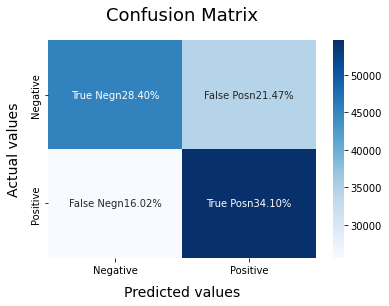

In [55]:
from sklearn.linear_model import LogisticRegression

LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
LRmodel.fit(x_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(x_test)

              precision    recall  f1-score   support

           0       0.59      0.52      0.56     79798
           1       0.58      0.64      0.61     80202

    accuracy                           0.58    160000
   macro avg       0.59      0.58      0.58    160000
weighted avg       0.59      0.58      0.58    160000



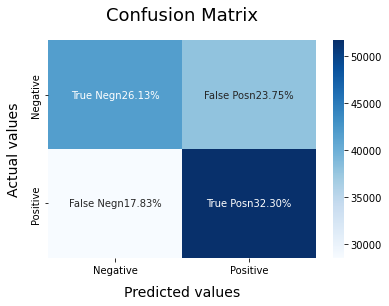

In [56]:
from sklearn.naive_bayes import BernoulliNB

BNBmodel = BernoulliNB()
BNBmodel.fit(x_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(x_test)

/home/antonis/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.64      0.57      0.60     79798
           1       0.61      0.68      0.65     80202

    accuracy                           0.62    160000
   macro avg       0.63      0.62      0.62    160000
weighted avg       0.63      0.62      0.62    160000



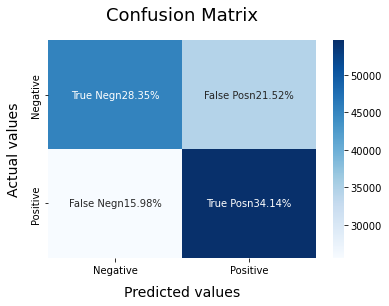

In [57]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(x_test)